<a href="https://colab.research.google.com/github/madhura206/Waste-Sorting-/blob/main/waste_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("techsash/waste-classification-data")
print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:08<00:00, 51.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


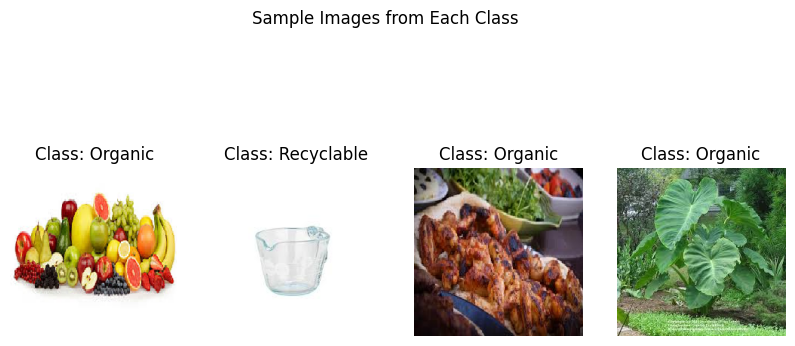

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths to the train and test directories
train_dir = r"/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN"
test_dir = r"/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST"

# Use ImageDataGenerator to prepare the data for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Display sample images from each class
plt.figure(figsize=(10, 5))
for i in range(4):  # Display 4 images (2 from each class if available)
    image, label = next(train_data)  # Use next() to get a batch of images
    plt.subplot(1, 4, i + 1)
    plt.imshow(image[0])  # Display the first image in the batch
    plt.title("Class: " + ("Organic" if label[0] == 0 else "Recyclable"))
    plt.axis('off')
plt.suptitle("Sample Images from Each Class")
plt.show()


# New Section

In [ ]:
#include_top=False: Excludes the fully connected layers at the top of MobileNetV2
#weights='imagenet': Uses pre-trained weights from the ImageNet dataset
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezes all the layers in the pre-trained MobileNetV2 to ensures that only the custom layers willlearn from new data
mobilenet_model.trainable = False

# Add custom layers for classification
model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(), #reduces the spatial dimensions of single vector(summation of matrix)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# We start with a pre-trained MobileNet model, adding layers to classify waste images into O or R.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=2
)

# After training the model, save it to a file
model.save('mobilenet_waste_classifier.h5')

loss, accuracy = model.evaluate(test_data)
print("Model Accuracy:", accuracy)

# The model learns over 5 epochs, seeing images in the training data, adjusting itself, and testing on new images.

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


706/706 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.8916 - loss: 0.2719 - val_accuracy: 0.9013 - val_loss: 0.2356
Epoch 2/2
706/706 ━━━━━━━━━━━━━━━━━━━━ 1089s 2s/step - accuracy: 0.9334 - loss: 0.1732 - val_accuracy: 0.8862 - val_loss: 0.2709


39/79 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8820 - loss: 0.2807

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate predictions
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
y_true = test_data.classes  # True labels from test data

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic', 'Recyclable']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Here, we measure the performance of the model.

In [ ]:
#save the model
model.save("ffd_model.h5")

In [ ]:
!pip install streamlit
!pip install gradio

In [ ]:
import gradio as gr
import tkinter as tk
from tkinter import filedialog

from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model

# Load the model
model = load_model("ffd_model.h5")
print("Model loaded successfully!")

# Function to load and predict an image
def predict_image(img):
  """Predicts whether an image contains wildfire or not.

  Args:
    img: The input image.

  Returns:
    A string indicating the prediction ("Wildfire" or "No Wildfire").
  """

  img = img.resize((224, 224))
  img_array = np.array(img) / 255.0  # Rescale like during training
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  prediction = model.predict(img_array)[0][0]  # Extracts the scalar prediction value
  result = "Organic" if prediction < 0.5 else "Non Organic"
  return result

# Create a Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),  # Input type is PIL Image
    outputs="text",
    title="Organic or Non Organic Waste Detector",
    description="Upload an image to predict whether it organic or not."
)

# Launch the interface
iface.launch()